# LSTM Implementation

# **Text Preprocessing**

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [2]:
# Specify the filename
input_file = 'holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [3]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [4]:
# Limit data to 500000 characters
data = data[:500000]

# Clean Text

In [5]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [6]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [7]:
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [8]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [9]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [10]:
X_train_temp

array([[   0,    0,    0, ...,    0,    0,  227],
       [   0,    0,    0, ...,    0,    0, 1377],
       [   0,    0,    0, ...,    0,    0, 1112],
       ...,
       [   0,    0,    0, ...,    0,    0,  108],
       [   0,    0,    0, ...,    2,  716,  631],
       [   0,    0,    0, ...,   27,    2,  699]])

# Train LSTM Model

In [11]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - accuracy: 0.0967 - loss: 6.2964 - val_accuracy: 0.1408 - val_loss: 5.6287
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.1535 - loss: 5.1443 - val_accuracy: 0.1533 - val_loss: 5.6057
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.1807 - loss: 4.6468 - val_accuracy: 0.1544 - val_loss: 5.7105
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.1997 - loss: 4.2729 - val_accuracy: 0.1526 - val_loss: 5.9239
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.2115 - loss: 4.0411 - val_accuracy: 0.1574 - val_loss: 6.1142
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.2308 - loss: 3.8508 - val_accuracy: 0.1554 - val_loss: 6.3586
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - accuracy: 0.2374 - loss: 3.7057 - val_accuracy: 0.1539 - val_loss: 6.5819
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - accuracy: 0.2549 -

2002/2002 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - accuracy: 0.3049 - loss: 3.2499 - val_accuracy: 0.1329 - val_loss: 11.1217


# Save Models (Weights and biases)

In [12]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model1.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model1.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


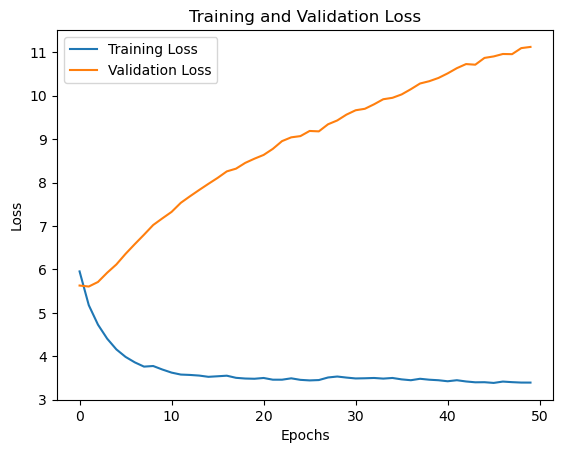

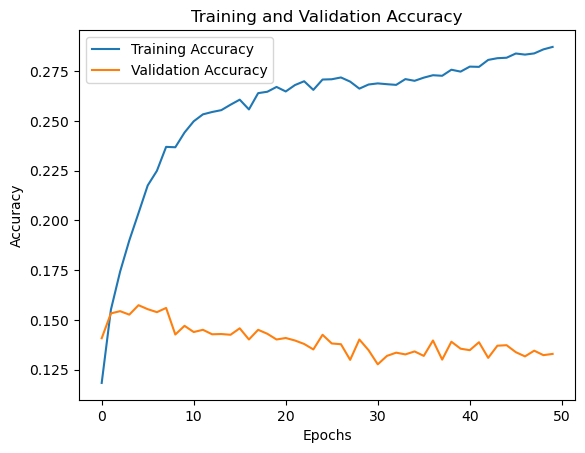

In [15]:

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Inferences

In [16]:
from IPython.display import display, HTML
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = [tokenizer.index_word[index] for index in top_five_indexes if index in tokenizer.index_word]
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = "<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = "<ul>" + "".join([f"<li>{seed_text} {word}</li>" for word in top_five_words]) + "</ul>"
    display(HTML(f"{heading_app}<br><hr>{output_text}"))


In [17]:
# Test the function
seed_text = "i am akash i am data scientist i was"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)

In [18]:
# Test 2:
# Test the function
seed_text = "Sorry sir, it happens by mistakely, I'm giving you access right now"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)